In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

from interfaces.db import DB

In [3]:
db = DB()

## Fetch data from database

In [4]:
# Get EPFLStartups
table_name = 'graph_piper.Nodes_N_EPFLStartup'
fields = ['EPFLStartupID', 'StartupName', 'Industry']
conditions = {'Status': 'Private'}
startups = pd.DataFrame(db.find(table_name, fields=fields, conditions=conditions), columns=fields)

In [5]:
# Get startups' founders
table_name = 'graph_piper.Edges_N_EPFLStartup_N_Person_T_Founder'
fields = ['EPFLStartupID', 'SCIPER']
startups_founders = pd.DataFrame(db.find(table_name, fields=fields), columns=fields)
founder_ids = list(startups_founders['SCIPER'].drop_duplicates())

In [6]:
# Get startups' professors
table_name = 'graph_piper.Edges_N_EPFLStartup_N_Person_T_Professor'
fields = ['EPFLStartupID', 'SCIPER']
startups_professors = pd.DataFrame(db.find(table_name, fields=fields), columns=fields)
professor_ids = list(startups_professors['SCIPER'].drop_duplicates())

In [7]:
# Get founders' concepts
table_name = 'graph_piper.Edges_N_Person_N_Concept_T_Research'
fields = ['SCIPER', 'PageID', 'Score']
conditions = {'SCIPER': founder_ids}
founders_concepts = pd.DataFrame(db.find(table_name, fields=fields, conditions=conditions), columns=fields)
founders_concept_ids = list(founders_concepts['PageID'].drop_duplicates())

In [8]:
# Get professors' concepts
table_name = 'graph_piper.Edges_N_Person_N_Concept_T_Research'
fields = ['SCIPER', 'PageID', 'Score']
conditions = {'SCIPER': professor_ids}
professors_concepts = pd.DataFrame(db.find(table_name, fields=fields, conditions=conditions), columns=fields)
professors_concept_ids = list(professors_concepts['PageID'].drop_duplicates())

In [9]:
# Get concepts
table_name = 'graph_piper.Nodes_N_Concept_T_Title'
fields = ['PageID', 'PageTitle']
conditions = {'PageID': founders_concept_ids + professors_concept_ids}
concepts = pd.DataFrame(db.find(table_name, fields=fields, conditions=conditions), columns=fields)

## Merge tables to obtain EPFLStartup-Concept edges

In [10]:
startups

,EPFLStartupID,StartupName,Industry
0,es-abionic,Abionic,Medtech
1,es-aeds,AEDS,Mechanical
2,es-aeler-technologies,Aeler Technologies,Mechanical
3,es-aesyra-aesybyte,Aesyra,Medtech
4,es-aica,Aica,Mechanical
...,...,...,...
252,es-xsensio-sarl,Xsensio Sarl,Micro-nanotech
253,es-xtenso,Xtenso,ICT
254,es-zace,Zace,ICT
255,es-zaphiro-technologies,Zaphiro Technologies,Electrical-electronics


In [11]:
startups_founders = pd.merge(startups, startups_founders, how='inner', on='EPFLStartupID')
startups_founders_concepts = pd.merge(startups_founders, founders_concepts, how='inner', on='SCIPER')
startups_founders_concepts = startups_founders_concepts.groupby(by=['EPFLStartupID', 'PageID']).aggregate({'Score': 'sum'}).reset_index()

In [12]:
startups_professors = pd.merge(startups, startups_professors, how='inner', on='EPFLStartupID')
startups_professors_concepts = pd.merge(startups_professors, professors_concepts, how='inner', on='SCIPER')
startups_professors_concepts = startups_professors_concepts.groupby(by=['EPFLStartupID', 'PageID']).aggregate({'Score': 'sum'}).reset_index()

In [17]:
startups_founders_concepts.describe()

,PageID,Score
count,4.426000e+03,4426.000000
mean,4.366315e+06,2.712742
std,9.641623e+06,6.382074
min,2.500000e+01,0.301765
25%,3.719900e+04,0.752383
50%,3.168625e+05,1.274365
75%,2.476345e+06,2.452348
max,6.242023e+07,140.813000


In [18]:
startups_professors_concepts.describe()

,PageID,Score
count,3.391500e+04,33915.000000
mean,4.635990e+06,2.744948
std,9.980400e+06,5.668253
min,2.500000e+01,0.301103
25%,4.025400e+04,0.847113
50%,3.150430e+05,1.468000
75%,2.627776e+06,2.728520
max,6.242023e+07,327.924000


In [7]:
import networkx as nx

In [8]:
G = nx.Graph()

In [9]:
nodes = [(i, {'label': i}) for i in range(1, 1 + 6)]
G.add_nodes_from(nodes)

In [10]:
edges = [(1, 2, {'weight': 0.9}), (1, 3, {'weight': 0.7}), (2, 3, {'weight': 0.5}), (3, 4, {'weight': 0.3}), (3, 5, {'weight': 0.4}), (4, 5, {'weight': 0.8}), (4, 6, {'weight': 0.6}), (5, 6, {'weight': 0.9})]
G.add_edges_from(edges)

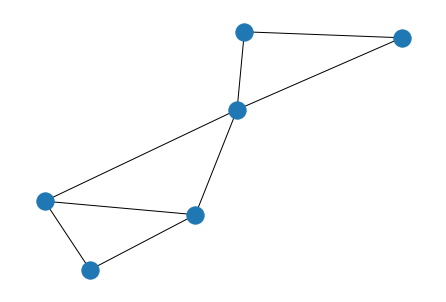

In [11]:
nx.draw(G)

In [12]:
nx.write_gexf(G, "test.gexf")